MachineLeaningCourse vol.3
# 回帰分析

## 重回帰分析



前回は、単回帰分析について勉強しました。
単回帰の線形モデルは以下のように定義されました。

$$y=w_0+w_1x$$

この線形モデルを__複数の説明変数__に合わせて一般化すると「__重回帰分析__」と呼ばれるものになります。
重回帰の線形モデルは以下のように定義されます。
$$y=w_0x_0+w_1x_1+ … +w_mx_m = \sum^{m}_{i=0} w_ix_i = w^Tx$$

ここで、$w_0$は、$x_0=1$としてy軸の切片を表しています。


これから、scikit-learnを使って、重回帰分析を実践していきましょう。

### ボストン市の住宅価格データセット
まず、今回の重回帰分析に使用するデータセットについて説明をします。

これは米国ボストン市郊外における地域別の住宅価格のデータセットです。

In [97]:
import pandas as pd
from sklearn.datasets import load_boston

# データセットを読み込み
housing = load_boston()
columns = housing.feature_names

# Pandasのデータフレームに変換
boston = pd.DataFrame(housing.data, columns=columns)

# 目的変数をDataFrameへ変換
boston['MEDV'] = np.array(housing.target)
columns = list(columns)
columns.append('MEDV')

# 最初の５件のデータを見る
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


#### 各特徴量の説明
|特徴量|説明|
|:--|:--|
|CRIM|人口 1 人当たりの犯罪発生数|
|ZN|25,000 平方フィート以上の住居区画の占める割合|
|INDUS|小売業以外の商業が占める面積の割合|
|CHAS|チャールズ川によるダミー変数 (1: 川の周辺, 0: それ以外)|
|NOX|NOx の濃度|
|RM|住居の平均部屋数|
|AGE|1940 年より前に建てられた物件の割合|
|DIS|5 つのボストン市の雇用施設からの距離 (重み付け済)|
|RAD|環状高速道路へのアクセスしやすさ|
|TAX|$10,000 ドルあたりの不動産税率の総計|
|PTRATIO|町毎の児童と教師の比率|
|B|町毎の黒人 (Bk) の比率を次の式で表したもの。 1000(Bk – 0.63)^2|
|LSTAT|給与の低い職業に従事する人口の割合 (%)|
|MEDV|住宅価格の中央値|

### データセットを可視化する
データの理解を深めるために、データセットを可視化して、視覚的に情報を得ることは機械学習モデルのトレーニングを行う前の重要なステップです。

主に、外れ値・データの分布・特徴量の関係を視覚的に検出します。

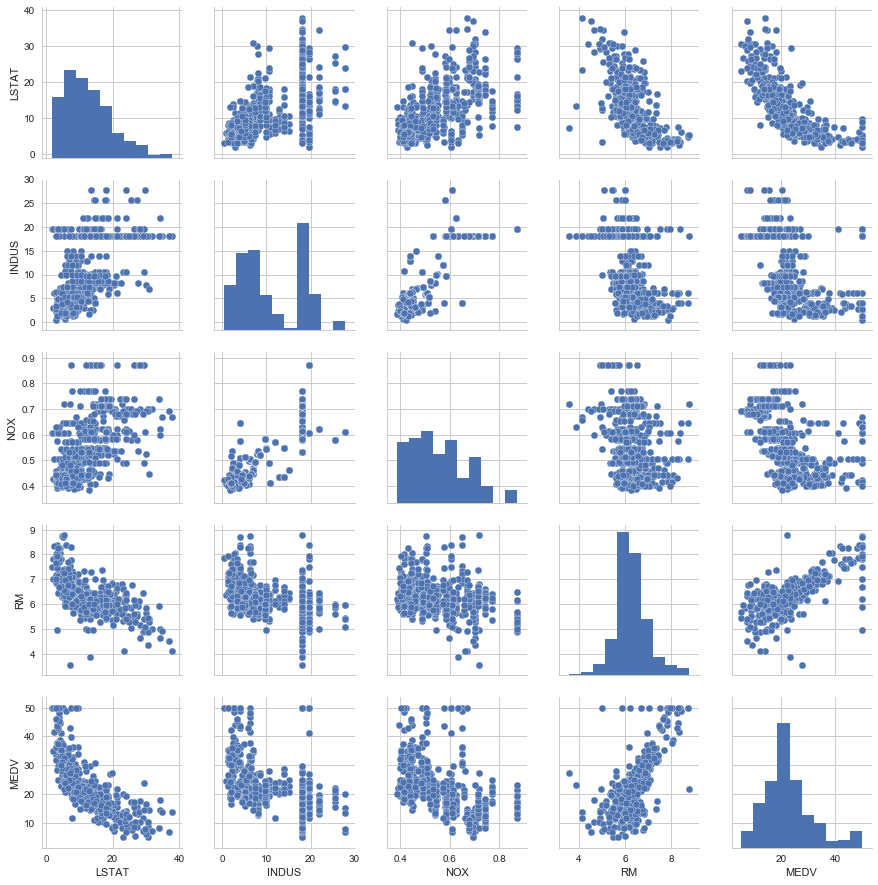

In [98]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# グラフのスタイルを指定
sns.set(style='whitegrid', context='notebook')

# プロットする特徴量の選択
cols = ['LSTAT', 'INDUS', 'NOX', 'RM', 'MEDV']

# 変数の関係をプロット
sns.pairplot(boston[cols], size=2.5)
plt.show()

seabornのpairplot関数によって描かれた散布図行列は、対角成分には各と特徴量のヒストグラムが描かれます。非対角成分には、散布図が描かれています。

RMとMEDVは正の相関が強いことがグラフから分かります。さらにMEDVのヒストグラムではほぼ正規分布にしたがうものの、__外れ値がいくつか含まれて居る__ことも分かります。

次に、特徴量の間の線形関係を数値化するために__相関行列__というものを作成します。

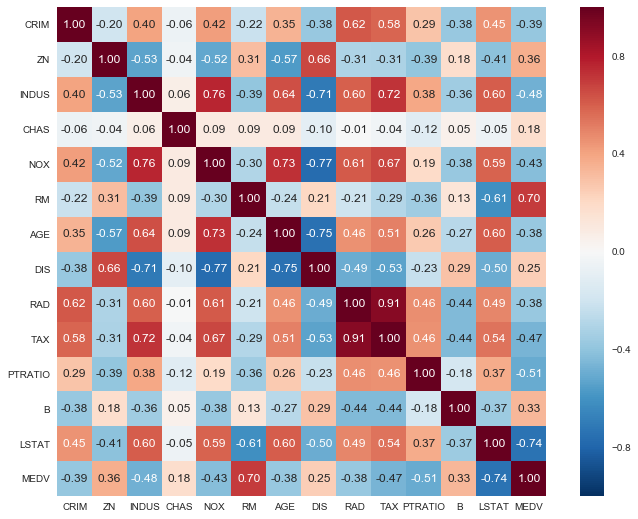

In [99]:
import numpy as np

# ピアソンの積率相関係数を計算
pearson = np.corrcoef(boston.values.T)
plt.figure(figsize=(12, 9))

# ヒートマップの作成
heat_map = sns.heatmap(pearson, cbar=True, annot=True, annot_kws={'size': 12},  square=True, fmt='.2f', xticklabels=columns, yticklabels=columns)

正の相関が強いと濃い赤、負の相関が強いと濃い青、無相関の場合は白に近くなります。


着目するべき所は、目的変数であるMEDVとの相関が強い特徴量です。この相関行列を見てみると、最も相関が高いのはLSTA（-0.74）、次にRM（0.70）という様になっています。

### データの分割
#### トレーニングデータとテストデータ
機械学習では一般に、データセットをトレーニングデータとテストデータの二つに分割して、トレーニングデータによる学習状況をテストデータでチェックしながら、テストデータに対して最も良い性能が出るようにチューニングしていきます。

![](https://s3.amazonaws.com/ai-standard/pic3-3.png)

この手法を__ホールドアウト法__と呼びます。

scikit-learnにはこれのための便利なモジュールが用意されているので、実際に使っていきましょう。

In [100]:
# 説明変数
X = boston.loc[:, housing.feature_names].values
# 目的変数
y = boston.loc[:, 'MEDV'].values


from sklearn.cross_validation import train_test_split

# トレーニングデータ：７割、テストデータ：３割にデータを分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

### 重回帰分析の実行

LinearRegressionの引数の説明をしておきます。
- fit_intercept : 切片項をモデル式に入れるかどうか。デフォルト値はTrue。
- normalize : 説明変数を正規化するかどうか。デフォルト値はFalse。
- copy_X : メモリ内でデータを複製してから実行するかどうか。 デフォルト値はTrue。
- n_jobs : 計算に使うジョブ数。デフォルト値は1で-1にするとすべてのCPUを使って計算。

In [101]:
from sklearn.linear_model import LinearRegression

model= LinearRegression()
model.fit(X_train, y_train)

# 作成したモデルから予測（学習用、検証用モデル使用）
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

### モデルの性能評価
![](https://s3.amazonaws.com/ai-standard/pic1-4.png)

機械学習ロードマップの「評価」にあたる部分の勉強をしていきます。

#### 残差プロット
回帰モデルを診断するために、予想された値に対する残差（実際の値と予測された値の差または縦の距離）をプロットすることを__残差プロット__と呼びます。

残差プロットをすることによって、回帰モデルを診断して非線形性や外れ値を検出して、__誤差がランダムに分布しているかどうか？__をチェックすることができます。

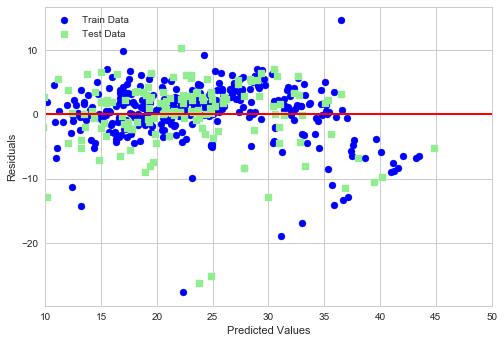

In [102]:
# 学習用、検証用それぞれで残差をプロット
plt.scatter(y_train_pred, y_train_pred - y_train, c = 'blue', marker = 'o', label = 'Train Data')
plt.scatter(y_test_pred, y_test_pred - y_test, c = 'lightgreen', marker = 's', label = 'Test Data')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

# 凡例を左上に表示
plt.legend(loc = 'upper left')

# y = 0に直線を引く
plt.hlines(y = 0, xmin = -10, xmax = 50, lw = 2, color = 'red')
plt.xlim([10, 50])
plt.show()

完璧な予想をすると、残差は０にりますが、実際にはそのようなことはまず起こらないでしょう。

ただし、よい回帰モデルでは、誤差がランダムに分布して、残差が中央の直線の周りに__ランダム__に散らばります。

ここでチェックするべきものは、
1. 誤差の期待値は０
2. 誤差は互いに無相関

という２点です。

#### 平均二乗誤差
モデルの性能を数値化するもう一つの効果的な手法として、平均二乗誤差（Meas Squared Error：MSE）があげられます。
これは、線形回帰モデルを学習させるために最小化した__誤差平方和コスト関数の平均値__です。

$$MSE = \frac{1}{n} \sum^{n}_{i=0} (y^{(i)}-\hat{y}^{(i)})^2$$


MSEは様々な回帰モデルの比較や、グリッドサーチと交差検証を通じたパラメータのチューニングに役立ちます。

In [103]:
from sklearn.metrics import mean_squared_error

# 学習用、検証用データに関して平均二乗誤差を出力
print('MSE Train : %.3f, Test : %.3f' % (mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)))

MSE Train : 19.966, Test : 27.184


トレーニングデータセットでの平均二乗誤差が19.966、テストデータセットでの平均二乗誤差がそれよりもかなり大きい27.184となっています。この値は、このモデルが若干__過学習__していることを意味します。

##### 決定係数 $R^2$
決定係数とは、モデルの性能をより効率的に解釈できるようにするための、__標準化された平均二乗誤差__です。

$R^2$は、モデルによって補足された応答の分散の割合を表しています。

$$ R^2 = \frac{MSE}{Var(y)}$$

要するに、
$$ R^2 = 1 - \frac{「観測値」と「予測値」の差の２乗和}{「観測値」と「観測値全体の平均」の２乗和}$$

ということを表しています。


観測値と予測値が真の値に近ければ、分子が0に近づき、$R^2$決定係数は１に近くなります。

値と、観測値のズレが大きい場合、分子は０から離れるため、$R^2$決定係数は１から離れます。

つまり、$R^2$__決定係数の値が１に近いほど、その予測モデルは良いモデル__と言えます。

In [104]:
# 学習用、検証用データに関してR^2を出力
print('R^2 Train : %.3f, Test : %.3f' % (mod.score(X_train, y_train), mod.score(X_test, y_test)))

R^2 Train : 0.762, Test : 0.690


In [111]:
# modelにも、R^2を求めるscore関数がついてます。
print('R^2 Train : %.3f, Test : %.3f' % (model.score(X_train, y_train), model.score(X_test, y_test)))

R^2 Train : 0.764, Test : 0.674


### モデルの磨き込み
上記の結果から、過学習ぎみな事が分かりました。
これの解決策として考えられる施策は以下です。

1. 正則化をして過学習を抑制する
2. モデルに非線形性を導入する

今後は、モデルの性能を上げるために上記の２つの方針でどんな手法があるのかを見ていきましょう。